# Simple SpikeInterface Demo

This demo shows the basic usage of SpikeInterface for:
1. Loading and preprocessing neural data
2. Basic spike detection
3. Computing essential quality metrics
4. Simple visualization


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface.core as si
import spikeinterface.extractors as se
import spikeinterface.widgets as sw
import spikeinterface.curation as sc
from spikeinterface.sortingcomponents.peak_detection import DetectPeakLocallyExclusive
from spikeinterface.qualitymetrics import compute_snrs, compute_firing_rates
from probeinterface import Probe


## Loading and Preprocessing Data

First, we'll load a Blackrock dataset and preprocess it for analysis. We'll handle single-channel data properly by reshaping as needed and setting up appropriate probe information.


In [58]:
print("Loading Blackrock dataset...")
# Use SpikeInterface's Blackrock extractor which handles the data properly
recording = se.BlackrockRecordingExtractor('/Users/nielsnovotny/Downloads/Hub1-datafile001.ns6')
channel_ids = recording.get_channel_ids()
print(f"Channel IDs: {channel_ids}")
traces = recording.get_traces(channel_ids=[channel_ids[0]])
print(f"Recording shape: {traces.shape} (using channel_ids=[{channel_ids[0]}])")
if traces.ndim == 1:
    traces = traces.reshape(-1, 1)
    print(f"Reshaped to 2D: {traces.shape}")
# Use NumpyRecording to ensure compatibility with single-channel data
from spikeinterface.core import NumpyRecording
recording = NumpyRecording(
    traces,
    sampling_frequency=recording.get_sampling_frequency(),
    channel_ids=[str(channel_ids[0])]
)
# Add gain information for scaling (assuming 1.0 gain for demo purposes)
recording.set_property("gain_to_uV", [1.0])
recording.set_property("offset_to_uV", [0.0])
print(f"Created NumpyRecording: {recording}")
print(f"Sampling frequency: {recording.get_sampling_frequency()} Hz")
print(f"Number of channels: {recording.get_num_channels()}")
print(f"Duration: {recording.get_total_duration()} seconds")


Loading Blackrock dataset...
Channel IDs: ['6']
Recording shape: (900210,) (using channel_ids=[6])
Reshaped to 2D: (900210, 1)
Created NumpyRecording: NumpyRecording: 1 channels - 30.0kHz - 1 segments - 900,210 samples - 30.01s - int16 dtype 
                1.72 MiB
Sampling frequency: 30000.0 Hz
Number of channels: 1
Duration: 30.007 seconds


/opt/anaconda3/envs/si_env/lib/python3.11/site-packages/neo/rawio/blackrockrawio.py:1037: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  npackets = int((filesize - offset) / np.dtype(ptp_dt).itemsize)
/opt/anaconda3/envs/si_env/lib/python3.11/site-packages/numpy/core/memmap.py:234: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  descr = dtypedescr(dtype)


## Setting up the Probe

Create and attach a probe object to our recording. For single-channel data, we'll create a simple probe with one contact. This is necessary since our recording doesn't have probe data.


In [59]:
# Create a probe with 1 shank and 1 channel
probe = Probe(ndim=2)
probe.set_contacts(
    positions=np.array([[0, 0]]),  # Single contact at origin
    shapes='circle',
    shape_params={'radius': 5},  # 5 micron radius
    shank_ids=[0]  # All contacts on shank 0
)
probe.set_device_channel_indices([0])  # Map channel 0 to contact 0

# Attach the probe to the recording
recording.set_probe(probe, in_place=True)
print(f"Probe attached: {recording.get_probe()}")


Probe attached: Probe - 1ch - 1shanks


## Spike Detection

We'll use threshold-based spike detection to identify potential spikes in our recording.


In [60]:
# Detect spikes using threshold detection
# Prepare arguments for detect_peaks
traces = recording.get_traces()
peak_sign = "neg"
abs_thresholds = np.array([5])  # threshold in standard deviations, one per channel
exclude_sweep_size = int(0.1 * recording.get_sampling_frequency() / 1000)  # 0.1 ms in samples
neighbours_mask = np.ones((1, 1), dtype=bool)  # For single channel, allow self-neighbor

peaks = DetectPeakLocallyExclusive.detect_peaks(
    traces, peak_sign, abs_thresholds, exclude_sweep_size, neighbours_mask
)
print(f"Detected {len(peaks[0])} peaks")

# peaks is a tuple: (sample_indices, channel_indices)
peaks_struct = np.zeros(
    len(peaks[0]),
    dtype=[("sample_index", "int64"), ("channel_index", "int64"), ("segment_index", "int64")]
)
peaks_struct["sample_index"] = peaks[0]
peaks_struct["channel_index"] = peaks[1]
peaks_struct["segment_index"] = 0  # All zeros for single segment

# Convert peaks to sorting
from spikeinterface.core import NumpySorting
sorting = NumpySorting.from_peaks(
    peaks_struct,
    sampling_frequency=recording.get_sampling_frequency(),
    unit_ids=["unit_0"]  # Single unit for all peaks
)
print(f"Created sorting with {len(sorting.get_unit_ids())} units")


Detected 63316 peaks
Created sorting with 1 units


## Creating SortingAnalyzer and Computing Extensions

The SortingAnalyzer is a powerful object that allows us to compute and store various metrics and features of our sorted data.


In [61]:
print("\nCreating SortingAnalyzer and computing metrics...")
analyzer = si.create_sorting_analyzer(
    sorting=sorting,
    recording=recording,
    format="memory"
)

# Compute metrics in the correct order
analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=600, seed=2205)  # Required for waveforms
analyzer.compute("waveforms", ms_before=1.0, ms_after=2.0, n_jobs=2)
analyzer.compute("templates", operators=["average"])
analyzer.compute("noise_levels")
analyzer.compute("principal_components", n_components=3, mode="by_channel_global", whiten=True)
analyzer.compute("spike_amplitudes")
analyzer.compute("quality_metrics")  # Required for auto curation
analyzer.compute("template_metrics")  # Required for auto curation

print(f"Analyzer created with all required metrics computed")



Creating SortingAnalyzer and computing metrics...


estimate_sparsity (no parallelization):   0%|          | 0/31 [00:00<?, ?it/s]

compute_waveforms (workers: 2 processes):   0%|          | 0/31 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/1 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/1 [00:00<?, ?it/s]

spike_amplitudes (no parallelization):   0%|          | 0/31 [00:00<?, ?it/s]

/opt/anaconda3/envs/si_env/lib/python3.11/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:157: UserWarning: Bin duration of 60s is larger than recording duration. Presence ratios are set to NaN.
  warnings.warn(
/opt/anaconda3/envs/si_env/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/si_env/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/si_env/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzer created with all required metrics computed


/opt/anaconda3/envs/si_env/lib/python3.11/site-packages/scipy/stats/_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/opt/anaconda3/envs/si_env/lib/python3.11/site-packages/scipy/stats/_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/opt/anaconda3/envs/si_env/lib/python3.11/site-packages/scipy/stats/_stats_py.py:10750: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


## Computing Quality Metrics

We'll compute various quality metrics to assess the quality of our sorted units.


In [62]:
print("\nComputing basic quality metrics...")
# Compute basic metrics
firing_rates = compute_firing_rates(analyzer)
snrs = compute_snrs(analyzer)

print("\nQuality metrics summary:")
print(f"Firing rate: {firing_rates['unit_0']:.2f} Hz")
print(f"SNR: {snrs['unit_0']:.2f}")



Computing basic quality metrics...

Quality metrics summary:
Firing rate: 2110.04 Hz
SNR: 0.88


In [63]:
print("\nPerforming simple automated curation based on quality metrics...")
# Get quality metrics
metrics = analyzer.get_extension("quality_metrics").get_data()

# Simple curation based on SNR and firing rate
good_units = []
for unit_id in analyzer.unit_ids:
    snr = metrics.loc[unit_id, "snr"]
    firing_rate = metrics.loc[unit_id, "firing_rate"]
    if snr > 0.8 and firing_rate > 0.1:  # SNR > 0.8 and firing rate > 0.1 Hz
        good_units.append(unit_id)

print("\nCuration results:")
print(f"Total units: {len(analyzer.unit_ids)}")
print(f"Good units: {len(good_units)}")
print(f"Good unit IDs: {good_units}")



Performing simple automated curation based on quality metrics...

Curation results:
Total units: 1
Good units: 1
Good unit IDs: ['unit_0']


/opt/anaconda3/envs/si_env/lib/python3.11/site-packages/spikeinterface/widgets/unit_waveforms.py:674: RuntimeWarning: invalid value encountered in divide
  gaus = np.exp(-0.5 * (eucl / eucl.min()) ** 2)  # sigma uses the min distance between channels


<Figure size 1000x500 with 0 Axes>

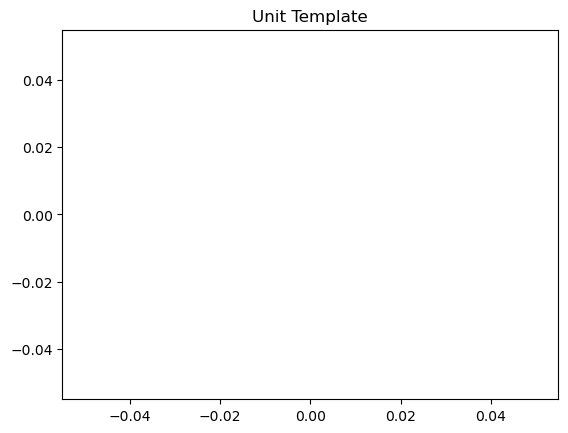

In [64]:
# Plot the unit template
plt.figure(figsize=(10, 5))
sw.plot_unit_templates(analyzer, unit_ids=["unit_0"])
plt.title('Unit Template')
plt.show()


## Visualizing Results

Let's visualize some of our results to better understand the quality of our units. We'll create plots showing:
1. Quality metrics distributions
2. Unit templates for high and low SNR units


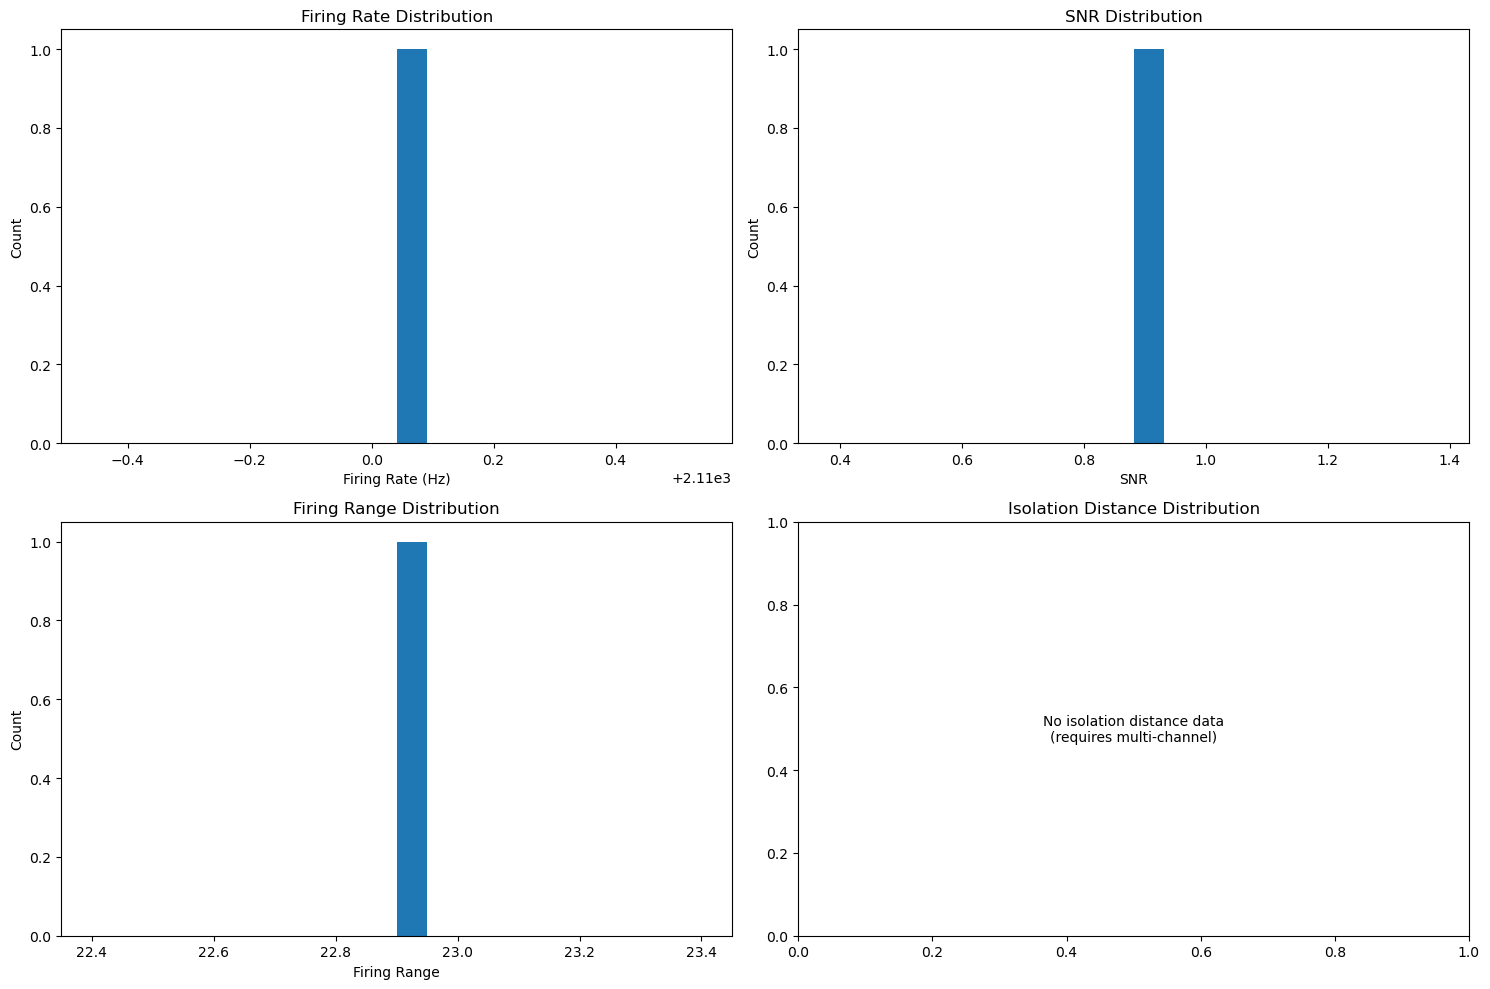

In [65]:
# Plot quality metrics distributions
plt.figure(figsize=(15, 10))

# Plot firing rates
plt.subplot(2, 2, 1)
plt.hist(metrics['firing_rate'], bins=20)
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Count')
plt.title('Firing Rate Distribution')

# Plot SNR distribution
plt.subplot(2, 2, 2)
plt.hist(metrics['snr'], bins=20)
plt.xlabel('SNR')
plt.ylabel('Count')
plt.title('SNR Distribution')

# Plot firing range distribution
plt.subplot(2, 2, 3)
plt.hist(metrics['firing_range'], bins=20)
plt.xlabel('Firing Range')
plt.ylabel('Count')
plt.title('Firing Range Distribution')

# Plot isolation distances
plt.subplot(2, 2, 4)
isolation_distances = metrics['isolation_distance'].dropna()  # Remove NaN values
if len(isolation_distances) > 0:
    plt.hist(isolation_distances, bins=20)
    plt.xlabel('Isolation Distance')
    plt.ylabel('Count')
    plt.title('Isolation Distance Distribution')
else:
    plt.text(0.5, 0.5, 'No isolation distance data\n(requires multi-channel)', 
            ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Isolation Distance Distribution')

plt.tight_layout()
plt.show()
